# Import libs

In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import collections
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from tqdm import tqdm

# Import RetinaNet architecture

In [3]:
!pip install gdown pycocotools

In [4]:
#!rm -r GSN

In [5]:
!gdown https://drive.google.com/uc?id=1JVwgJeXSkcgoEDEuMDaG5HTFvqu7cerZ

^C


In [6]:
#!unzip -q GSN.zip

In [10]:
from GSN.WiderDataLoader.wider_loader import WiderFaceDataset
from GSN.WiderDataLoader.wider_batch_iterator import BatchIterator
from GSN.model.RetinaNet import RetinaNet, evaluate
from GSN.model.Utils import show_image, draw_loss

# Test device

In [11]:
!nvidia-smi

Fri Jan 12 16:13:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:26:00.0  On |                  N/A |
| 57%   40C    P8              14W / 184W |   1442MiB / 12288MiB |     19%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Prepare data

## Set variables

In [13]:
DATA_DIR = 'WIDER'
NUM_CLASSES = 1
BATCH_SIZE = 20
LEARNING_RATE = 2e-5
EPOCHS_NUM = 10

## Download dataset

In [14]:
#!rm -r WIDER
#!gdown "1jDU6gTyKwWDZL0YRuKhxz69rmjVJmVRW"

In [15]:
#!unzip -q WIDER.zip

In [16]:
transform = Compose([ToPILImage(), Resize((512, 800)), ToTensor(),Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [17]:
wider_train_dataset = WiderFaceDataset(DATA_DIR, split='train', transform=transform, augment=True)
wider_val_dataset = WiderFaceDataset(DATA_DIR, split='val', transform=transform, augment=False)
wider_test_dataset = WiderFaceDataset(DATA_DIR, split='test', transform=transform, augment=False)

train_data = BatchIterator(wider_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data = BatchIterator(wider_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_data = BatchIterator(wider_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Prepare drive to save model

To save model weights on google drive

In [18]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [19]:
#drive_path = '/content/'
#drive_path = '/content/gdrive/MyDrive/Colab Notebooks/GSN_PROJ_FILES/RetinaNet_weights/'
drive_path = 'RetinaNet_weights/'

# Model

## Init

### Init new model

In [20]:
model = RetinaNet().to(device)

### Download and init pretrain model

In [21]:
# !gdown  10JQgb01MsceilLNixz1abdkpZzl4sht3 # pretrained on 20 epochs

In [22]:
saved_weights = torch.load('model_59.pth', map_location=device)
model.load_state_dict(saved_weights)

<All keys matched successfully>

### Init optimizer

In [23]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

## Train

In [24]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 285845 KiB | 285845 KiB | 285845 KiB |      0 B   |\n|       from large pool | 246272 KiB | 246272 KiB | 246272 KiB |      0 B   |\n|       from small pool |  39573 KiB |  39573 KiB |  39573 KiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         | 285845 KiB | 285845 KiB | 285845 KiB |      0 B   |\n|       from large pool | 246272 KiB | 246272 KiB |

In [25]:
loss_hist = collections.deque(maxlen=500)
regr_hist = collections.deque(maxlen=500)
clas_hist = collections.deque(maxlen=500)
loss_val_hist = collections.deque(maxlen=500)
regr_val_hist = collections.deque(maxlen=500)
clas_val_hist = collections.deque(maxlen=500)
best_valid_loss = float('Inf')

for epoch_num in range(EPOCHS_NUM):
    epoch_loss = []
    regr_loss = []
    clas_loss = []

    model.train()
    for iter_num, data in enumerate(tqdm(train_data, desc=f'Epoch {epoch_num}')):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            classification_loss, regression_loss = model([data['img'].cuda().float(), data['boxes_list'].cuda()])
        else:
            classification_loss, regression_loss = model([data['img'].float(), data['boxes_list']])
        loss = classification_loss + regression_loss
        if loss == 0:
            continue
        epoch_loss.append(float(loss))
        regr_loss.append(float(regression_loss))
        clas_loss.append(float(classification_loss))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()


    average_loss = np.mean(epoch_loss)
    average_clas_loss = np.mean(clas_loss)
    average_regr_loss = np.mean(regr_loss)
    loss_hist.append(average_loss)
    regr_hist.append(average_regr_loss)
    clas_hist.append(average_clas_loss)
    print(f'Epoch: {epoch_num}/{EPOCHS_NUM} | Average Loss: {average_loss} | Classification loss: {float(average_clas_loss):1.5f} | Regression loss: {float(average_regr_loss):1.5f}')
    scheduler.step()

    epoch_loss = []
    regr_loss = []
    clas_loss = []
    for iter_num, data in enumerate(val_data):
        if torch.cuda.is_available():
            classification_loss, regression_loss = model([data['img'].cuda().float(), data['boxes_list'].cuda()])
        else:
            classification_loss, regression_loss = model([data['img'].float(), data['boxes_list']])
        loss = classification_loss + regression_loss
        if bool(loss == 0):
            continue
        epoch_loss.append(float(loss))
        regr_loss.append(float(regression_loss))
        clas_loss.append(float(classification_loss))
    average_loss = np.mean(epoch_loss)
    average_clas_loss = np.mean(clas_loss)
    average_regr_loss = np.mean(regr_loss)
    loss_val_hist.append(average_loss)
    regr_val_hist.append(average_regr_loss)
    clas_val_hist.append(average_clas_loss)
    print(
        f'Evaluate | Average Loss: {average_loss} | Classification loss: {float(average_clas_loss):1.5f} | Regression loss: {float(average_regr_loss):1.5f}')


    if epoch_num % 4 == 0:
      try:
          model.eval()
          evaluate(dataset=wider_val_dataset, model=model, threshold=0.05)
      except Exception as e:
          print(f"Error: {e}")

    if epoch_num > EPOCHS_NUM-10 and best_valid_loss > average_loss:
        best_valid_loss = average_loss
        filename = f'model_{epoch_num}.pth'
        print("Saved model!")
        torch.save(model.state_dict(), drive_path + "training/" + filename)
    if epoch_num+1 % 20 == 0:
        filename = f'model_{epoch_num}.pth'
        print("Saved model!")
        torch.save(model.state_dict(), drive_path + "training/" + filename)

Epoch 0: 184it [06:33,  2.14s/it]                                                                                      


Epoch: 0/10 | Average Loss: 1.1240454494305279 | Classification loss: 0.46945 | Regression loss: 0.65459
Evaluate | Average Loss: 1.2219015670859295 | Classification loss: 0.43715 | Regression loss: 0.78475
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.95s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  

Epoch 1: 184it [06:43,  2.19s/it]                                                                                      


Epoch: 1/10 | Average Loss: 1.01141928460287 | Classification loss: 0.38928 | Regression loss: 0.62214
Evaluate | Average Loss: 1.1906053553456846 | Classification loss: 0.42389 | Regression loss: 0.76671
Saved model!


Epoch 2: 184it [06:33,  2.14s/it]                                                                                      


Epoch: 2/10 | Average Loss: 0.9789986555343089 | Classification loss: 0.37598 | Regression loss: 0.60301
Evaluate | Average Loss: 1.25945093061613 | Classification loss: 0.46301 | Regression loss: 0.79644


Epoch 3: 184it [05:59,  1.95s/it]                                                                                      


Epoch: 3/10 | Average Loss: 0.9591661085901053 | Classification loss: 0.36335 | Regression loss: 0.59582
Evaluate | Average Loss: 1.2292283345823702 | Classification loss: 0.49285 | Regression loss: 0.73638


Epoch 4: 184it [05:58,  1.95s/it]                                                                                      


Epoch: 4/10 | Average Loss: 0.9375138088412907 | Classification loss: 0.35443 | Regression loss: 0.58308
Evaluate | Average Loss: 1.2338563929433408 | Classification loss: 0.43527 | Regression loss: 0.79858
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.14s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  

Epoch 5: 184it [06:20,  2.07s/it]                                                                                      


Epoch: 5/10 | Average Loss: 0.9284420447505038 | Classification loss: 0.34462 | Regression loss: 0.58382
Evaluate | Average Loss: 1.255429762861003 | Classification loss: 0.44754 | Regression loss: 0.80789


Epoch 6: 184it [06:35,  2.15s/it]                                                                                      


Epoch: 6/10 | Average Loss: 0.9128422040654265 | Classification loss: 0.33956 | Regression loss: 0.57328
Evaluate | Average Loss: 1.1785399512104366 | Classification loss: 0.41839 | Regression loss: 0.76015
Saved model!


Epoch 7: 184it [05:51,  1.91s/it]                                                                                      


Epoch: 7/10 | Average Loss: 0.9166757383424303 | Classification loss: 0.33831 | Regression loss: 0.57837
Evaluate | Average Loss: 1.1795309937518577 | Classification loss: 0.41813 | Regression loss: 0.76140


Epoch 8: 184it [05:48,  1.89s/it]                                                                                      


Epoch: 8/10 | Average Loss: 0.9040745972939159 | Classification loss: 0.33341 | Regression loss: 0.57067
Evaluate | Average Loss: 1.2145778821862263 | Classification loss: 0.45582 | Regression loss: 0.75876
creating index...
index created!
Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.34s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  

Epoch 9: 184it [06:49,  2.23s/it]                                                                                      


Epoch: 9/10 | Average Loss: 0.9003444372311883 | Classification loss: 0.33177 | Regression loss: 0.56857
Evaluate | Average Loss: 1.2275062747623608 | Classification loss: 0.44730 | Regression loss: 0.78021


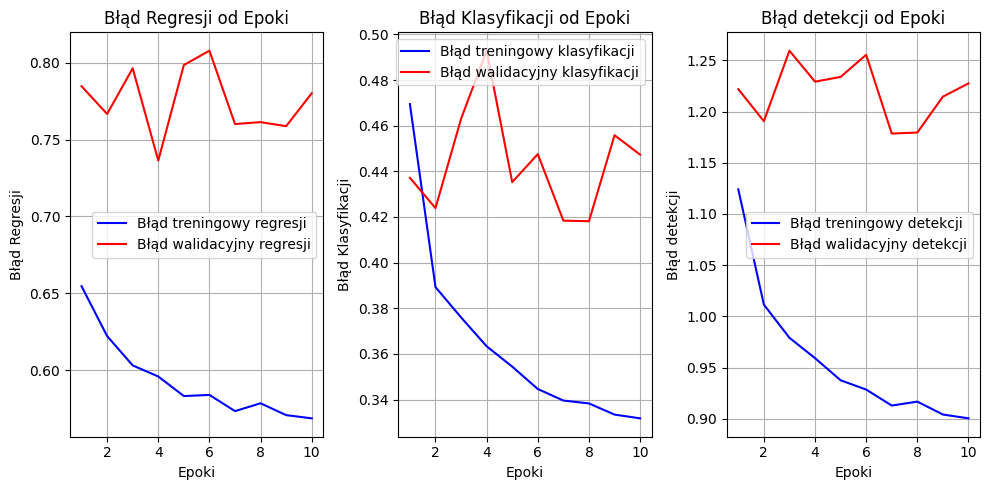

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(regr_hist) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, regr_hist, 'b', label='Błąd treningowy regresji')
plt.plot(epochs, regr_val_hist, 'r', label='Błąd walidacyjny regresji')
plt.title('Błąd Regresji od Epoki')
plt.xlabel('Epoki')
plt.ylabel('Błąd Regresji')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, clas_hist, 'b', label='Błąd treningowy klasyfikacji')
plt.plot(epochs, clas_val_hist, 'r', label='Błąd walidacyjny klasyfikacji')
plt.title('Błąd Klasyfikacji od Epoki')
plt.xlabel('Epoki')
plt.ylabel('Błąd Klasyfikacji')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, loss_hist, 'b', label='Błąd treningowy detekcji')
plt.plot(epochs, loss_val_hist, 'r', label='Błąd walidacyjny detekcji')
plt.title('Błąd detekcji od Epoki')
plt.xlabel('Epoki')
plt.ylabel('Błąd detekcji')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## Training loss

## Evaluate loaded model

In [ ]:
model.eval()
try:
    evaluate(dataset=wider_val_dataset, model=model, threshold=0.1)
except Exception as e:
    print(f"Error: {e}")

## Predict boxes in images using a loaded model

In [ ]:
print(len(wider_val_dataset))

print(model)

In [ ]:
model.set_eval_thresholds(nms_threshold=0.5, score_threshold=0.25)
for i in range(0, len(wider_val_dataset), 20):
    data = wider_val_dataset[i]
    model.eval()
    if torch.cuda.is_available():
        scores, labels, boxes = model([data['img'].cuda().float().unsqueeze(0), data['boxes_list'].cuda().unsqueeze(0)])
    else:
        scores, labels, boxes = model([data['img'].float().unsqueeze(0), data['boxes_list'].unsqueeze(0)])
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    inverse_normalize_transform = Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )
    image = inverse_normalize_transform(data['img'])

    boxes = boxes.cpu()
    with torch.no_grad():
        show_image(image, boxes)